# Assignment 1 - $k$-nearest neighbor
## Task 1 - Visualization
Visualize the data stored in `DataSet1.csv`!

In [1]:
from typing import Literal, Sequence

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
from numpy.random import rand
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as KNN

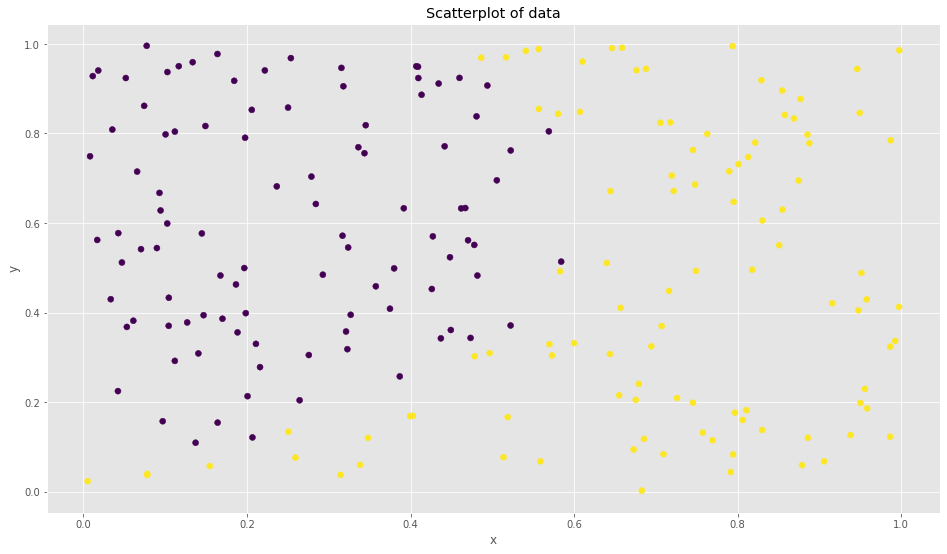

In [2]:
# read data
Z = np.genfromtxt('DataSet1.csv', delimiter=',')
X, y = Z[:, :-1], Z[:, -1]

# plot data
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Scatterplot of data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Questions 
 - Why is $k$-nearest neighbor possibly a reasonable approach?

### Answers
 - As we can see in the plot above, the data is very well clustered; thus a $k$-nearest neighbor approach will yield very accurate predictions

## Task 2 - Training the model
Use k-nearest neighbor classifiers with $k \in \{1,3,5,...,47,49,51\}$. Either use the `kNeigbhors` function from `sklearn` or implement it on your own (bonus points!). In order to estimate the generalization error, use 10-fold cross validation. Visualize your results (plot $k$ vs. error rates).

In [3]:
def trainModel(X: np.ndarray, y: np.ndarray, /, *, K: Sequence[int], K_Fold: int = 5,
               seed: int = 0, method: Literal['my', 'sklearn'] = 'sklearn'):
    accuracies = []

    for k in K: 
        kf = KFold(n_splits=K_Fold, shuffle=True, random_state=seed)
        curr = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            knnc = KNN(k) if method == 'sklearn' else KNearestNeighborClassifier(k)
            knnc.fit(X_train, y_train)
            
            curr.append(accuracy_score(y_test, knnc.predict(X_test)))
        accuracies.append(np.mean(curr))

    plt.figure(figsize=(16, 9))
    plt.plot(
        K,
        1 - np.asarray(accuracies),
        c='red',
        linestyle='dashed',
        marker='o',
        markerfacecolor='b'
    )
    plt.title('Error Rate vs. k')
    plt.xlabel('k')
    plt.ylabel('generalisation error')
    plt.show()

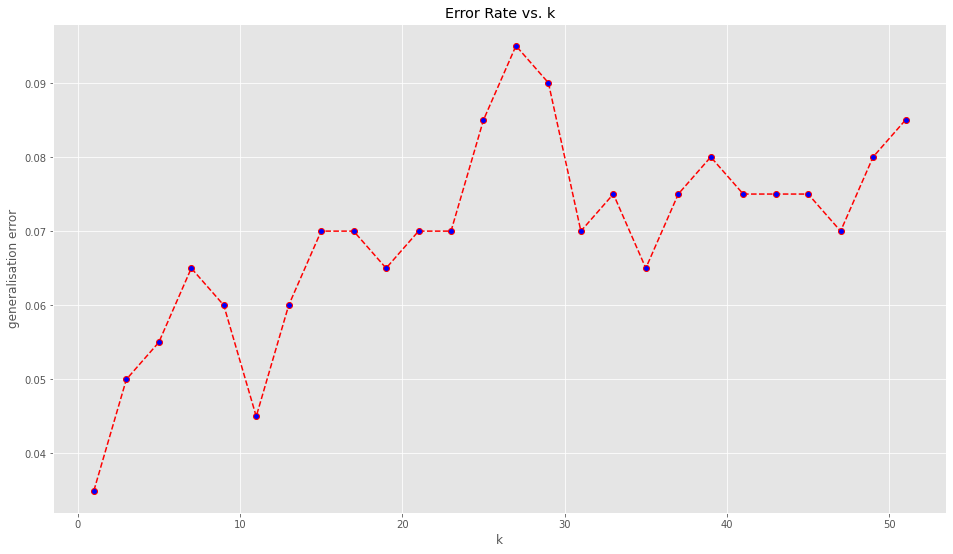

In [4]:
trainModel(X, y, K = range(1, 53, 2))

### Questions
 - Thinking of model complexity as the ability of the model to fit to noise, what choice of $k$ gives complex models? Why?
 - How does the error develop with the model complexity? Why?

### Answers
 - A lower $k$ will result in better scaling abilities (not too low to avoid overfitting) $\xrightarrow{}$ when $k$ gets too large, we are prone to underfitting
 - The error increases with increasing $k$; the 'border'-regions are prone to underfitting therefore the error-rate scales with $k$. 

## Task 3 - Label noise
Flip the sign of the labels of the data randomly with probability of $\frac{1}{5}$. Perform the same steps as before.

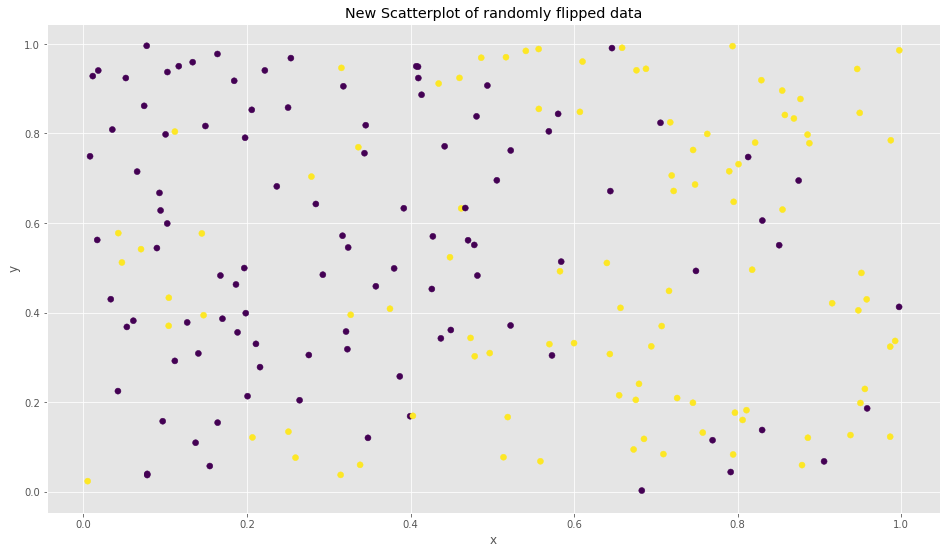

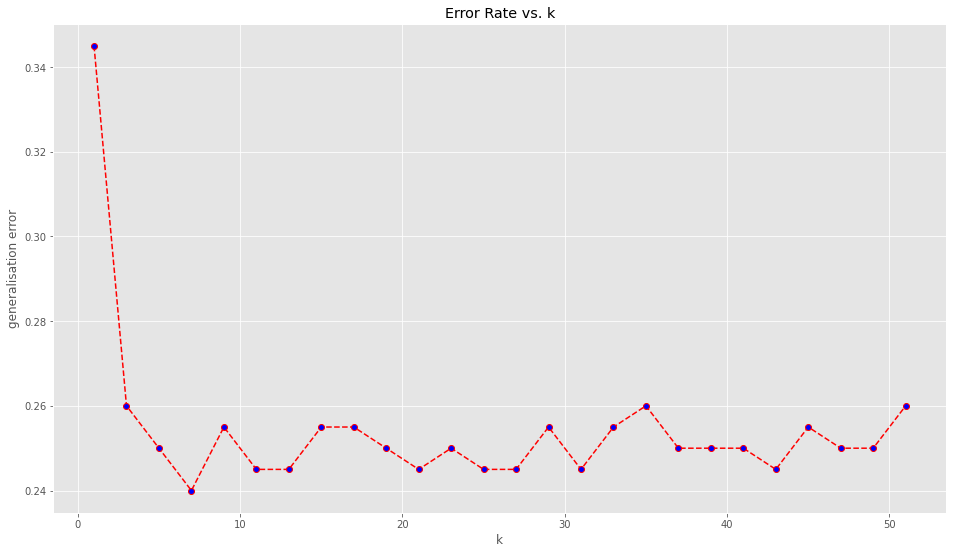

In [5]:
# for reproducibility
np.random.seed(0)

y_noise = y.copy()

for i in range(len(y_noise)):
    if rand() < 1/5: 
        y_noise[i] = -y_noise[i]

plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y_noise)
plt.title('New Scatterplot of randomly flipped data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

trainModel(X, y_noise, K=range(1, 53, 2))

### Questions
 - Which differences do you observe?
 - Which conclusions do you draw from that?

### Answers
 - For small $k$s ($k \leq 5$) we introduce a very high error rate, as to be expected from overfitting. The error averages on around 5\% + the manually introduced 20\%.
 - Since in real-life there will always be some noise, we can conclude that very small $k$s ($k \leq 5$) cannot deal with noise very well (overfitting!); On the other hand, very high $k$s underfit the model and introduce higher generalisation-errors.

## Task 4 - $k$-NN in higher dimensions
Add four random features to the data matrix $X$ which are uniformly distributed between 0 an 1. Perform the same steps as before.

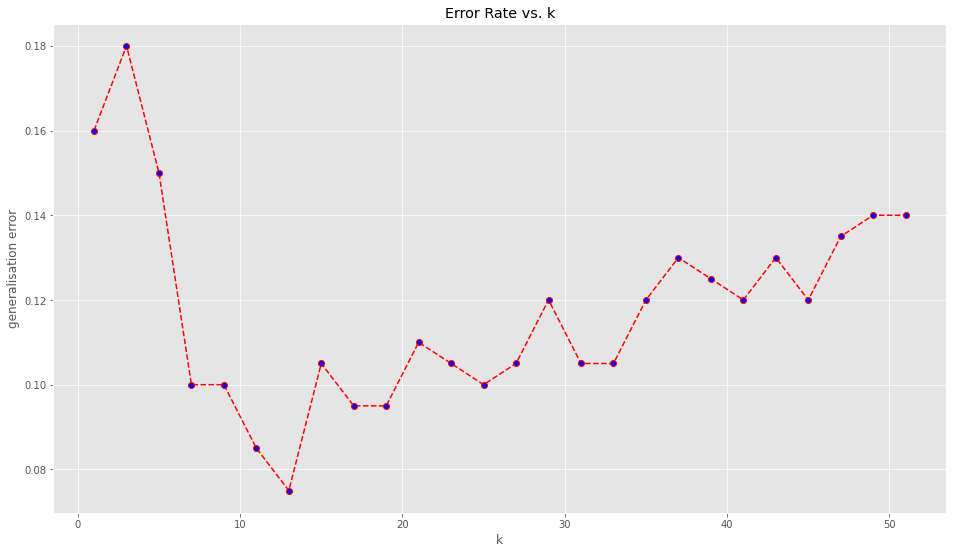

In [6]:
np.random.seed(0)

rFeatures = rand(X.shape[0], 4)
X_new = np.concatenate((X, rFeatures), axis=1)

trainModel(X_new, y, K=range(1, 53, 2))

### Questions
 - Try to explain possible changes of the generalization error and the best $k$

### Answers
 - Of course introducing more random dimensions introduces more generalization error. To my surprise the effects were rather small $\xrightarrow{}$ with just 16\% error. 
 - Small $k$s ($k \leq 5 \xrightarrow{}$ overfitting) and big $k$s ($k > 20 \xrightarrow{}$ underfitting) lead to higher error rates. For this case the best $k$s are $13$ and $17$. Calculating the result seeds average around $k \in [11, 19]$.

## Task 5 - Own $k$-NN implementation

In [7]:
class KNearestNeighborClassifier:

    def __init__(self, k: int, /):
        self.k = k
        self._X = None
        self._y = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, /):
        self._X = X_train.copy()
        self._y = y_train.copy()

    def predict(self, X_test: np.ndarray, /) -> np.ndarray:
        if self._X is None or self._y is None:
            raise AttributeError('KNN not fitted!')

        predict = []
        for elem in X_test:
            distances = [(np.sum((X - elem)**2), y) for X, y in zip(self._X, self._y)]
            result = sorted(distances, key=lambda tup: tup[0])[:self.k]
            predict.append(1 if sum(d[1] for d in result) >= 0 else -1)
        return np.asarray(predict)

Original data set - sklearn


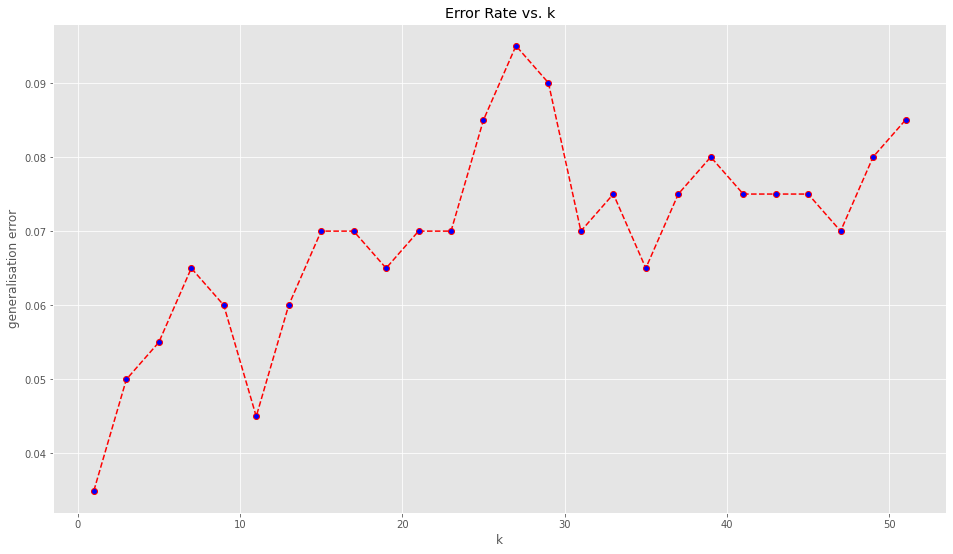

Original data set - my KNearestNeightborClassifier


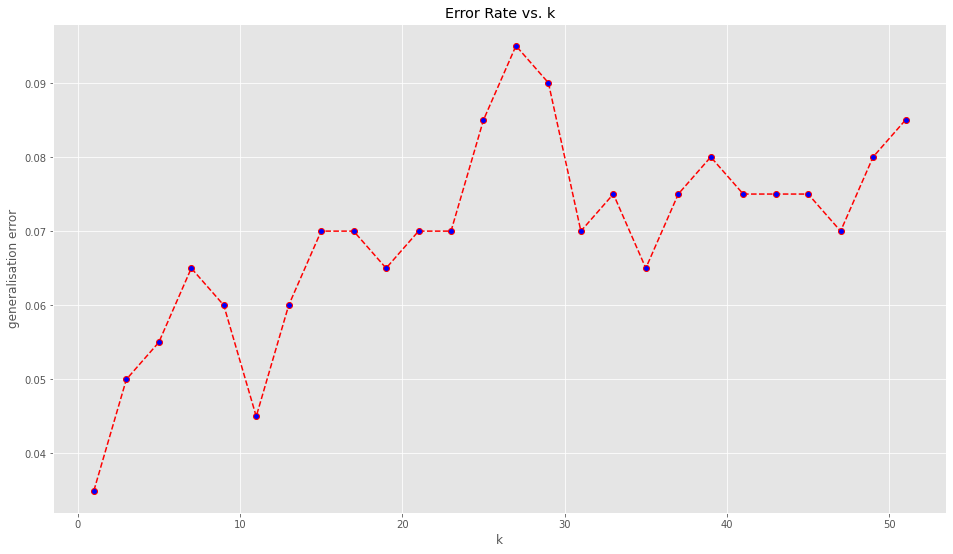

Noisy data set - sklearn


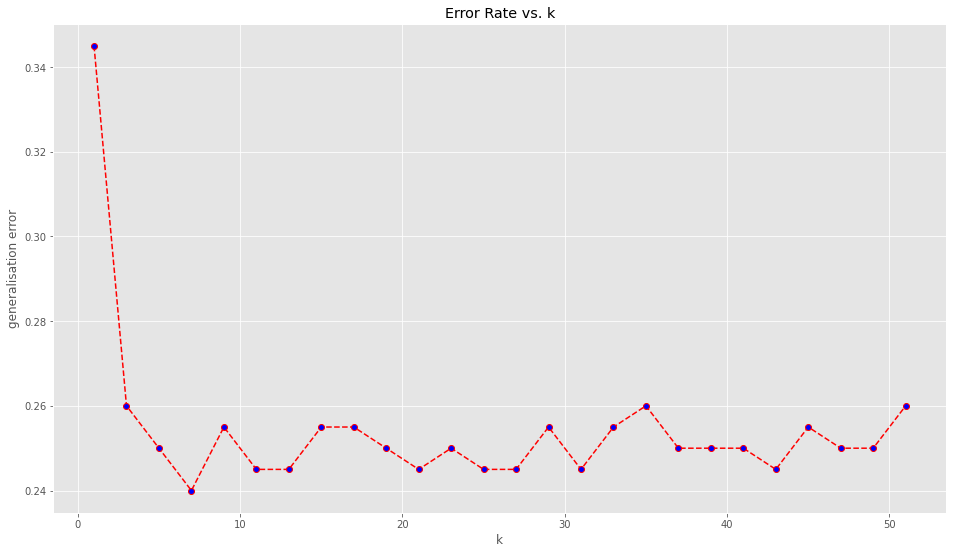

Noisy data set - my KNearestNeightborClassifier


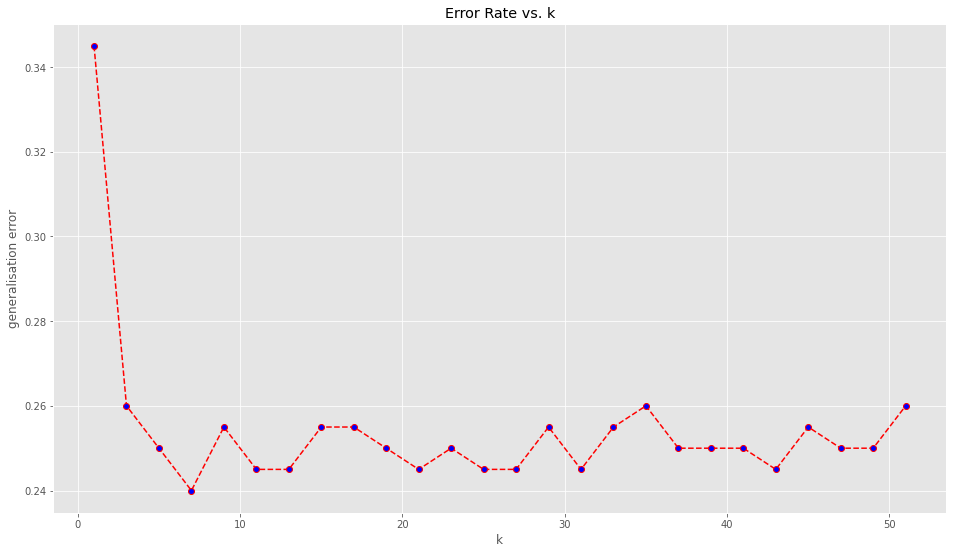

Multi dimensional data set - sklearn


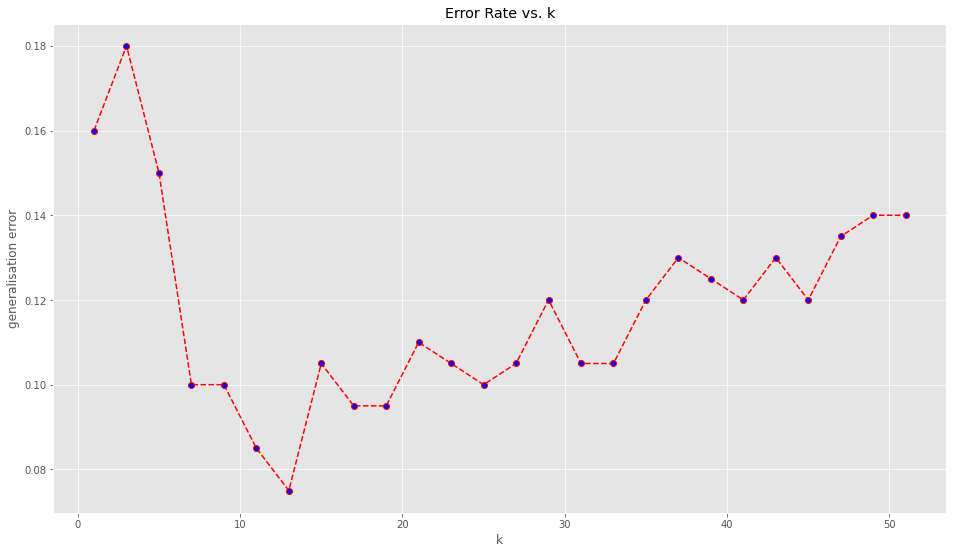

Multi dimensional data set - my KNearestNeightborClassifier


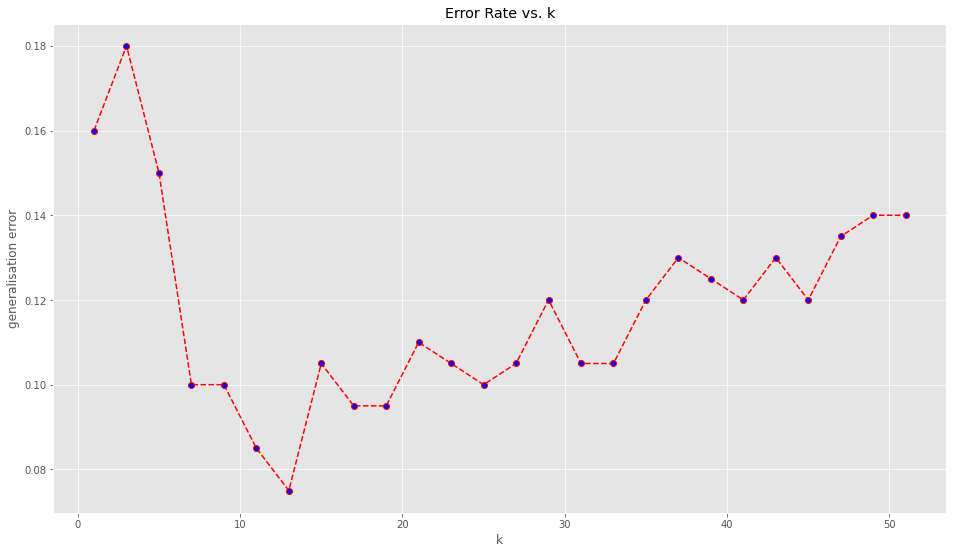

In [8]:
print('Original data set - sklearn')
trainModel(X, y, K=range(1, 53, 2), method='sklearn')
print('Original data set - my KNearestNeightborClassifier')
trainModel(X, y, K=range(1, 53, 2), method='my')

print('Noisy data set - sklearn')
trainModel(X, y_noise, K=range(1, 53, 2), method='sklearn')
print('Noisy data set - my KNearestNeightborClassifier')
trainModel(X, y_noise, K=range(1, 53, 2), method='my')

print('Multi dimensional data set - sklearn')
trainModel(X_new, y, K=range(1, 53, 2), method='sklearn')
print('Multi dimensional data set - my KNearestNeightborClassifier')
trainModel(X_new, y, K=range(1, 53, 2), method='my')